The purpose of this calculation is to reproduce the results from [Asuncion et al., Philippine Journal of Science, 2019](https://github.com/pgniewko/conotoxins/tree/master/papers/ML/ASA.PJS.2019.pdf). The data used in this work is downloaded from the [ConoServer](http://www.conoserver.org/?page=download) (access data: 11/18/19). Instead of using [protr](https://cran.r-project.org/web/packages/protr/vignettes/protr.html) package for peptides featurizaion, we use a Python implementation [pydpi](https://pypi.org/project/pydpi/#files). Other tools could be also used e.g. [iFeature](https://github.com/Superzchen/iFeature/) by [Chen et al., Bioinformatics 2018](https://github.com/pgniewko/conotoxins/tree/master/papers/ML/iFeature.2018.pdf).

In [1]:
import sys
import xml.etree.ElementTree as ET


from toxin import Toxin
from experiment import Experiment


import seaborn as sns
import matplotlib.pyplot as plt


import numpy as np
from scipy import stats
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
db_file = "../data/conoserver/conoserver_protein.xml"
tree = ET.parse(db_file)
root = tree.getroot()

toxins = []
for entry in root.iter('entry'):
    pid = entry.find('id').text if entry.find('id') is not None else None
    seq = entry.find('sequence').text if entry.find('sequence') is not None else "None"
    name = entry.find('name').text if entry.find('name') is not None else "None"
    toxin_class =  entry.find('class').text if entry.find('class') is not None else "None"
    organism = entry.find('organismLatin').text if entry.find('organismLatin') is not None else "None"
    geneSuperfamily = entry.find('geneSuperfamily').text if entry.find('geneSuperfamily') is not None else "None"
    cysteineFramewrok = entry.find('cysteineFramewrok').text if entry.find('cysteineFramewrok') is not None else "None"
    pharmacologicalFamily = entry.find('pharmacologicalFamily').text if entry.find('pharmacologicalFamily') is not None else "None"
    isoelecticPoint = entry.find('isoelecticPoint').text if entry.find('isoelecticPoint') is not None else "None"
    
    toxin = Toxin(pid,
                  seq,
                  name,
                  toxin_class,
                  organism,
                  geneSuperfamily,
                  cysteineFramewrok,
                  pharmacologicalFamily, 
                  isoelecticPoint)
    
    mods = entry.find('sequenceModifications')
    if mods is not None:
        for mod in mods.iter('modification'):
            toxin.add_modification( mod.attrib )
    
    toxin._clean_seq()
    toxins.append(toxin)

Changes made to the sequeunces that couldn't be found in (done manually)

1. P06822;X2->W;O6-P;X24->C;
2. P07401;X2->E;X3->E;X7->X;X10->"";
3. P07646;O4>P;O10->P;
4. P07647;O4>P;O10->P;

In [3]:
experiment = Experiment(toxins, min_val=8)
if False:
    experiment.prepare_experiment()
else:
    experiment.experiment_from_file('../data/ASA.PJS.2019.txt')

data, labels, labels_map = experiment.get_data()   

Can't find protein with id P06822. Createing a new object with seq: GWCGDPGATCGKLRLYCCSGFCDCYTKTCKDKSSA and class: sodium
Can't find protein with id P07401. Createing a new object with seq: GEEEYSEAI and class: NMDARs
Can't find protein with id P07646. Createing a new object with seq: CKPPGSKCSPSMRDCCTTCISYTKRCRKYY and class: calcium
Can't find protein with id P07647. Createing a new object with seq: CKPPGSKCSPSMRDCCTTCISYTKRCRKYYN and class: calcium
GCPWDPWC
Skipping P01270 protein, with a sequence: GCPWDPWC
GCPWDPWC
Skipping P01272 protein, with a sequence: GCPWDPWC
GDCPKPWC
Skipping P01309 protein, with a sequence: GDCPKPWC


In [65]:
data_cleaded = []
for i in range(data.shape[1]):
    std= np.std(data[:,i])
    if std != 0:
        data_cleaded.append(data[:,i])
data_cleaded = np.array(data_cleaded)
data_cleaded = data_cleaded.T

zscores = stats.zscore(data_cleaded, axis=0, ddof=1)
pca = PCA(n_components=137)
newData = pca.fit_transform(zscores)

Text(0, 0.5, 'dim 2')

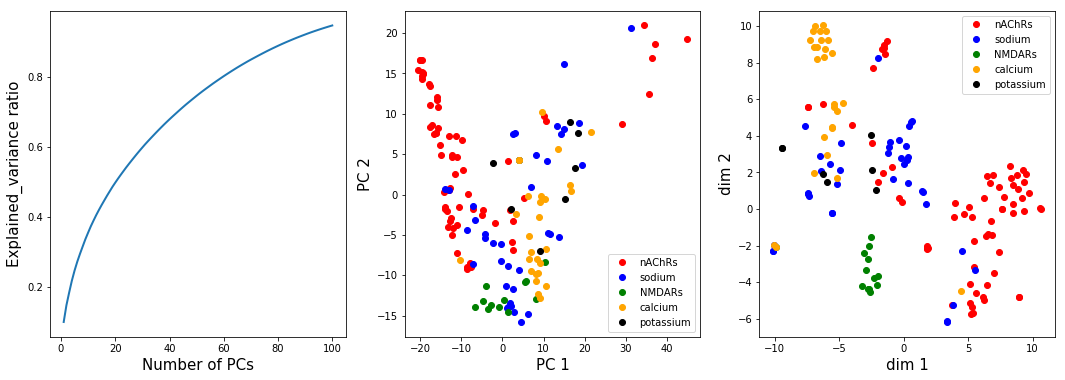

<Figure size 504x504 with 0 Axes>

In [16]:
fig, axis = plt.subplots(1, 3, figsize=(18,6))

ax1 = axis[0]
ax2 = axis[1]
ax3 = axis[2]


y = np.cumsum(pca.explained_variance_ratio_)
x = [i+1 for i in range(len(y))]

fig = plt.figure(figsize=(7, 7))
ax1.plot(x, y, lw=2)
ax1.set_xlabel('Number of PCs', fontsize=15)
ax1.set_ylabel('Explained_variance ratio', fontsize=15)




color_map = {0:'red', 1:'blue', 2:'green', 3:'orange', 4:'black'}

for label, color in color_map.items():
    x = [newData[i,0] for i in range(len(labels)) if labels[i] == label]
    y = [newData[i,1] for i in range(len(labels)) if labels[i] == label]
    ax2.plot(x,y,'o', c=color, label=labels_map[label])
ax2.legend()
ax2.set_xlabel("PC 1", fontsize=15)
ax2.set_ylabel("PC 2", fontsize=15)

X_embedded = TSNE(n_components=2).fit_transform(newData[:,0:10])

for label, color in color_map.items():
    x = [X_embedded[i,0] for i in range(len(labels)) if labels[i] == label]
    y = [X_embedded[i,1] for i in range(len(labels)) if labels[i] == label]
    ax3.plot(x,y,'o', c=color, label=labels_map[label])
ax3.legend()
ax3.set_xlabel("X 1", fontsize=15)
ax3.set_ylabel("X 2", fontsize=15)

In [81]:
precision_recall_fscore_support(clf.predict(X_test), y_test)

(array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([15,  8,  4,  4]))

In [90]:
import numpy as np
from sklearn.model_selection import KFold

X = newData[:,0:137]
y = labels
y_true = []
y_pred = []
kf = KFold(n_splits=50, random_state=42, shuffle=True )
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = OneVsRestClassifier(LogisticRegression(solver='newton-cg')).fit(X_train, y_train)
    y_pred += list(clf.predict(X_test))
    y_true += list(y_test)

In [91]:
print(f1_score(y_true, y_pred, average='weighted'))
print(precision_score(y_true, y_pred,average='weighted'))
print(recall_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true, y_pred))

0.84502082180736
0.8654529983695125
0.8562091503267973
0.8562091503267973


In [92]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_true, y_pred)

(array([0.92957746, 0.72093023, 1.        , 0.80769231, 1.        ]),
 array([0.97058824, 0.81578947, 0.92307692, 0.77777778, 0.14285714]),
 array([0.94964029, 0.7654321 , 0.96      , 0.79245283, 0.25      ]),
 array([68, 38, 13, 27,  7]))

In [93]:
confusion_matrix(y_true, y_pred)

array([[66,  2,  0,  0,  0],
       [ 3, 31,  0,  4,  0],
       [ 0,  0, 12,  1,  0],
       [ 0,  6,  0, 21,  0],
       [ 2,  4,  0,  0,  1]])

In [94]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(y_true, y_pred))

0.7906976744186047
